In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_boston,make_moons
from sklearn.preprocessing import MinMaxScaler
from sklearn.inspection import permutation_importance,plot_partial_dependence
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor,MLPClassifier
from mlxtend.plotting import plot_decision_regions

## 一、sklearn估计回归问题的神经网络

In [2]:
data=load_boston()
X=pd.DataFrame(data=data.data,columns=data.feature_names)
y=data.target
xtrain,xtest,ytrain,ytest=train_test_split(X,y,test_size=0.3,random_state=1)

In [3]:
scaler=MinMaxScaler().fit(xtrain)
xtrain=scaler.transform(xtrain)
xtest=scaler.transform(xtest)

In [4]:
xtrain.min(axis=0),xtrain.max(axis=0)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]))

L-BFGS算法是一种准牛顿算法，使用近似的黑塞矩阵，适用于较小的数据集；adam算法基于随机梯度下降法，适用于较大的数据集；sgd则是标准的随机剃度。

In [5]:
model=MLPRegressor(hidden_layer_sizes=(5),solver='lbfgs',random_state=123,max_iter=10000)

In [6]:
model.fit(xtrain,ytrain)

MLPRegressor(hidden_layer_sizes=5, max_iter=10000, random_state=123,
             solver='lbfgs')

In [7]:
model.intercepts_#第一个数组表示对应5个神经元的截距项，第二个数组表示输出层的截距项

[array([-0.48128497, 14.06793283, -3.68386784, -8.32226828, -1.47201143]),
 array([11.25579966])]

In [8]:
model.coefs_#第一个数组表示每个特征变量所对应的5个神经元的权重系数，第二个数组表示5个神经元到输出层的权重系数

[array([[ 2.26820487e-01, -1.18330345e+01,  1.92846349e-01,
         -5.78480152e-01,  2.02166074e-01],
        [-8.87723441e-02,  2.36724991e+00,  2.15276301e+00,
         -7.18041604e-01, -3.55559005e-01],
        [-1.81048436e-01,  1.11897750e+00,  5.74519045e-01,
          2.16341799e+00, -6.63850064e-01],
        [ 2.74761834e-01,  1.94410380e+00,  4.41135832e-01,
         -1.55963192e+00, -1.29426219e-01],
        [ 1.55163726e-01, -7.19856513e+00,  6.30939932e-01,
          4.87994506e+00, -2.22581627e-01],
        [-2.04391061e-01, -2.36052906e+00,  3.68275046e+00,
          1.44838591e+01, -7.05412222e-01],
        [-4.70908229e-01,  1.23320214e+00, -2.66670282e+00,
         -2.41088145e+00, -1.04923701e+00],
        [-2.16741372e-01, -7.35691088e+00,  1.63533189e+00,
          2.55807118e+00, -4.12559699e-01],
        [ 1.43101672e-01,  4.78939829e+00,  5.04140125e+00,
         -2.74320180e+00, -8.23638887e-02],
        [-2.88095232e-01, -1.72531913e+00,  4.98912697e+00,
    

Text(0.5, 1.0, 'Neural Network Weights')

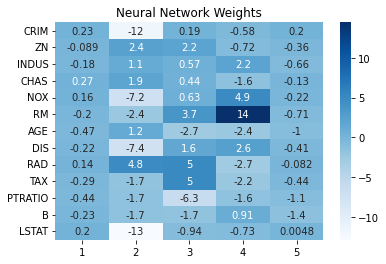

In [9]:
table=pd.DataFrame(model.coefs_[0],index=X.columns,columns=[1,2,3,4,5])
sns.heatmap(table,fmt='.2g',annot=True,cmap='Blues')
plt.title('Neural Network Weights')

从权重热图可看出，变量RM对第四个神经元的权重最大。

下面计算每个特征变量的置换重要性：对于某个特征变量，将此变量的观测值排序随机打乱，重估模型并计算测试集的拟合优度，所得拟合优度的差值即为变量重要性、

In [10]:
results=permutation_importance(model,xtest,ytest,n_repeats=20,random_state=42)
dir(results)

['importances', 'importances_mean', 'importances_std']

Text(0.5, 1.0, 'Permutation Importances')

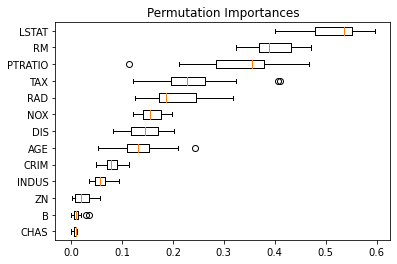

In [11]:
index=results.importances_mean.argsort()
plt.boxplot(results.importances[index].T,labels=X.columns[index],vert=False)#需转置
plt.title('Permutation Importances')

In [12]:
scores=[]
for n_neure in range(1,41):
    model=MLPRegressor(solver='lbfgs',hidden_layer_sizes=(n_neure),random_state=123,max_iter=10000)
    model.fit(xtrain,ytrain)
    scores.append(model.score(xtest,ytest))

In [13]:
index=np.argmax(scores)
range(1,41)[index],scores[index]

(15, 0.9068716180785776)

Text(0.5, 1.0, 'Test R2 versus Number of Nodes')

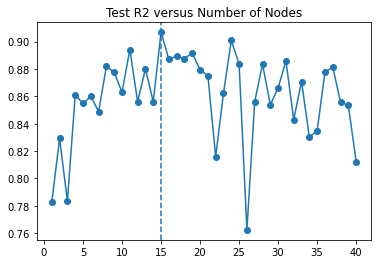

In [14]:
plt.plot(range(1,41),scores,'o-')
plt.axvline(x=range(1,41)[index],linestyle='--')
plt.title('Test R2 versus Number of Nodes')

In [15]:
b_score=0
b_nodes=(1,1)
for i in range(1,11):
    for j in range(1,11):
        model=MLPRegressor(solver='lbfgs',max_iter=10000,random_state=123,hidden_layer_sizes=(i,j))
        model.fit(xtrain,ytrain)
        score=model.score(xtest,ytest)
        if score>b_score:
            b_score=score
            b_nodes=(i,j)

In [16]:
b_score,b_nodes

(0.9119893743478638, (9, 5))

可见，对于最优的双隐藏层模型，其第一和第二隐藏层分别包含9个和5个神经元，且拟合优度为0.912
## 二、sklearn估计分类问题的神经网络

In [17]:
data=pd.read_csv('/Users/singal/Desktop/Data/MLPython_Data/spam.csv')
X=data.iloc[:,:-1]
y=data.iloc[:,-1]
xtrain,xtest,ytrain,ytest=train_test_split(X,y,test_size=0.2,random_state=0)
scaler=MinMaxScaler().fit(xtrain)
xtrain=scaler.transform(xtrain)
xtest=scaler.transform(xtest)

In [18]:
xtrain.min(axis=0),xtrain.max(axis=0)

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1.]))

In [19]:
model=MLPClassifier(solver='adam',hidden_layer_sizes=(100,),max_iter=10000,random_state=123)
model.fit(xtrain,ytrain)

MLPClassifier(max_iter=10000, random_state=123)

In [20]:
model.score(xtest,ytest)

0.9381107491856677

对于较复杂的数据，一般需使用比较丰富的网络结构，以避免欠拟合。但由于网络结构的多样性，通常很难选择最优的网络结构。通常作法为，设定一个足够丰富的网络结构，然后通过”早退“或者“权重衰减”进行正则化处理。

In [21]:
model=MLPClassifier(solver='adam',hidden_layer_sizes=(500,500),random_state=123,max_iter=10000,early_stopping=True,validation_fraction=0.25)
model.fit(xtrain,ytrain)
model.score(xtest,ytest)

0.9261672095548317

make_moons函数默认生成两类确定性数据：

In [22]:
X,y=make_moons(n_samples=100)
data=pd.DataFrame(X,columns=['x1','x2'])

<AxesSubplot:xlabel='x1', ylabel='x2'>

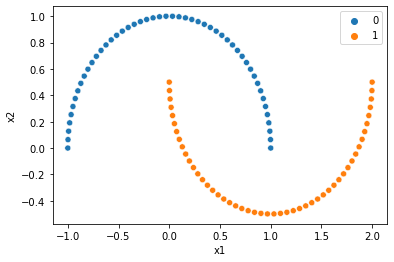

In [23]:
sns.scatterplot(x='x1',y='x2',data=data,hue=y)

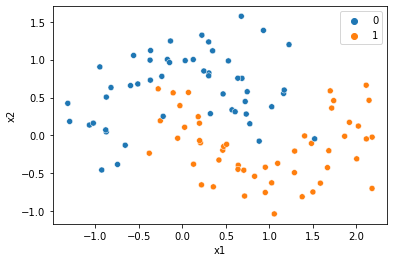

In [24]:
X,y=make_moons(n_samples=100,noise=0.3,random_state=0)#noise表示加入一个标准差为0.3的正态随机变量
data=pd.DataFrame(X,columns=['x1','x2'])
sns.scatterplot(x='x1',y='x2',data=data,hue=y)
xtrain=X
ytrain=y

In [25]:
xtest,ytest=make_moons(n_samples=1100,noise=0.4,random_state=0)
xtest=xtest[100:,:]
ytest=ytest[100:]

In [26]:
xtest

array([[ 0.27226427,  1.09909353],
       [ 0.67400587,  0.22958188],
       [ 0.49267145, -0.44854786],
       ...,
       [ 1.79771291, -0.17306326],
       [ 0.37697632,  0.90100297],
       [ 0.24328137,  0.27660524]])

In [27]:
model=MLPClassifier(hidden_layer_sizes=(100,100),random_state=123,max_iter=10000)
model.fit(xtrain,ytrain)
model.score(xtest,ytest)

0.847

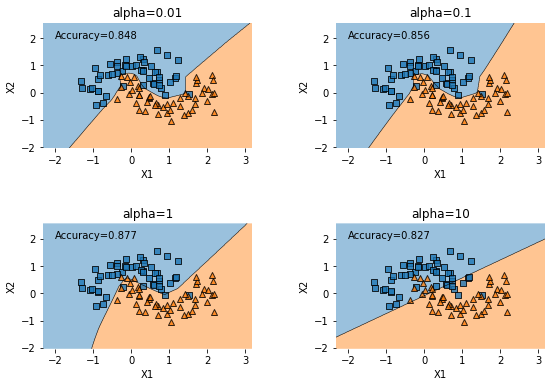

In [28]:
plt.figure(figsize=(9,6))
for i,alpha in enumerate([0.01,0.1,1,10]):
    model=MLPClassifier(hidden_layer_sizes=(100,100),alpha=alpha,random_state=123,max_iter=10000)
    model.fit(xtrain,ytrain)
    accuracy=model.score(xtest,ytest)
    plt.subplot(2,2,i+1)
    plot_decision_regions(xtrain,ytrain,model,legend=0)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title(f'alpha={alpha}')
    plt.text(-2,2,f'Accuracy={accuracy}')
plt.subplots_adjust(hspace=0.6,wspace=0.4)

当惩罚参数为0.01时，决策边界较不光滑，表明存在过拟合，反之当惩罚参数为10时，决策边界为线性，预测准确度也较低，表明存在欠拟合。故最优惩罚参数为alpha=1。
## 三、Keras估计回归问题的神经网络

In [29]:
import os
import random as rn
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras import regularizers
import keras
from keras.datasets import mnist,reuters,boston_housing
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import MinMaxScaler

In [30]:
(xtrain,ytrain),(xtest,ytest)=boston_housing.load_data(test_split=0.2,seed=113)

In [31]:
xtrain.shape,xtest.shape

((404, 13), (102, 13))

In [32]:
scaler=MinMaxScaler().fit(xtrain)
xtrain=scaler.transform(xtrain)
xtest=scaler.transform(xtest)

1. Sequential类用于构建一系列神经层线性排放而成的神经网络模型。
2. add方法为实例model添加一个稠密层，即全连接层，第一个参数表示输出维度，即神经元个数，第二个变量表示激活函数，第三个变量明确输入数据的形状，由于此隐藏层（第一个隐藏层）接收输入数据，故需明确输入数据的形状。添加两个隐藏层后，最后一个add方法表示添加输出层。
3. compile方法用于配置训练模型。

In [33]:
def build_model():
    model=Sequential()
    model.add(Dense(256,activation='relu',input_shape=(xtrain.shape[1],)))
    model.add(Dense(256,activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='rmsprop',loss='mse',metrics=['mese'])
    return model

In [34]:
model=build_model()
model.summary()#得到此网络模型的概要信息

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               3584      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 69,633
Trainable params: 69,633
Non-trainable params: 0
_________________________________________________________________


3584/256=14，表示13个特征变量和一个偏置；65792/256=257，表示隐藏层1的256个输出值再加上一个偏置。

In [35]:
hist=model.fit(xtrain,ytrain,validation_split=0.25,epochs=300,batch_size=16,shuffle=False)

In [1]:
hist

hist
